In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from statistics import mode

# --- Setup ---
print("--- Step 0: Libraries Imported ---")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set seaborn style for plots
sns.set_theme(style="whitegrid")

print("✓ All libraries imported successfully.")

--- Step 0: Libraries Imported ---
✓ All libraries imported successfully.


## Step 1: Data Merging and Cleaning

We will merge the two main datasets — technical information of meters (`Per-metre.csv`) and daily consumption time series (`Consum.csv`) — ensuring relational consistency through the shared key `POLISSA_SUBM`. During this process, we will verify data integrity, remove duplicated or invalid records, and prepare the data for analysis by creating time-based features.

In [12]:
print("--- Starting Step 1: Data Loading, Merging, and Cleaning ---")
# Filter the DataFrame to keep only rows where POLISSA_SUBM is NOT the specified ID
unified_df_filtered = unified_df[unified_df['POLISSA_SUBM'] != '6C3M54YW4J6HKY26']
# --- 0. Load Data ---
consum_dades = pd.read_parquet("Mostra Set de dades 4_Incidències en comptadors intel·ligents_Consum.parquet")
perimetre_dades = pd.read_parquet("Mostra Set de dades 4_Incidències en comptadors intel·ligents_Perímetre.parquet")
print("✓ Data loaded successfully.")
print(f"  - 'consum_dades' shape: {consum_dades.shape}")
print(f"  - 'perimetre_dades' shape: {perimetre_dades.shape}")


if not consum_dades.empty and not perimetre_dades.empty:
    # --- 1. Merge Datasets ---
    print("\n--- Merging Datasets ---")
    unified_df = pd.merge(
        consum_dades,
        perimetre_dades,
        on="POLISSA_SUBM",
        how="inner"
    )
    print(f"✓ Datasets merged on 'POLISSA_SUBM'. New shape: {unified_df.shape}")

    # --- 2. Verify Integrity and Clean Data ---
    print("\n--- Verifying Integrity and Cleaning ---")

    # Remove duplicated time series records (same meter, same date)
    initial_rows = unified_df.shape[0]
    unified_df.drop_duplicates(subset=['POLISSA_SUBM', 'DATA'], keep='first', inplace=True)
    rows_after_dupes = unified_df.shape[0]
    print(f"  - Removed {initial_rows - rows_after_dupes} duplicate records (same meter & date).")

    # Remove invalid records (e.g., negative consumption)
    initial_rows = unified_df.shape[0]
    unified_df = unified_df[unified_df['CONSUM'] >= 0]
    rows_after_invalid = unified_df.shape[0]
    print(f"  - Removed {initial_rows - rows_after_invalid} invalid records (negative consumption).")

    # --- 3. Assess Completeness & Feature Engineering ---
    print("\n--- Assessing Completeness & Feature Engineering ---")

    try:
        unified_df['DATA'] = pd.to_datetime(unified_df['DATA'])
        unified_df['DATA_INST_COMP'] = pd.to_datetime(unified_df['DATA_INST_COMP'])
        print("✓ Converted 'DATA' and 'DATA_INST_COMP' to datetime objects.")
        
        # Create time features for EDA
        unified_df['YEAR'] = unified_df['DATA'].dt.year
        unified_df['MONTH'] = unified_df['DATA'].dt.month
        unified_df['DAY_OF_WEEK'] = unified_df['DATA'].dt.dayofweek
        # Create log-transformed consumption for normalized analysis
        unified_df['CONSUM_LOG'] = np.log1p(unified_df['CONSUM'])
        print("✓ Created time features (YEAR, MONTH, DAY_OF_WEEK) and CONSUM_LOG.")
        
        min_date = unified_df['DATA'].min()
        max_date = unified_df['DATA'].max()
        print(f"\n  - Daily consumption data ranges from: {min_date.date()} to {max_date.date()}")
        
        print("\n  - Record count by year:")
        print(unified_df['YEAR'].value_counts().sort_index())
        
        print("\n  - Meter count by brand (MARCA_COMP):")
        print(unified_df.drop_duplicates(subset=['POLISSA_SUBM'])['MARCA_COMP'].value_counts())
        
    except Exception as e:
        print(f"Could not convert date columns or create features: {e}")

    print("\n--- Data Preparation Finished ---")
    print("Data is ready in 'unified_df' DataFrame.")
    print("\n--- DataFrame Info ---")
    unified_df.info()
else:
    print("Data loading failed. Skipping preparation.")

--- Starting Step 1: Data Loading, Merging, and Cleaning ---
✓ Data loaded successfully.
  - 'consum_dades' shape: (14439, 3)
  - 'perimetre_dades' shape: (10, 6)

--- Merging Datasets ---
✓ Datasets merged on 'POLISSA_SUBM'. New shape: (14439, 8)

--- Verifying Integrity and Cleaning ---
  - Removed 0 duplicate records (same meter & date).
  - Removed 0 invalid records (negative consumption).

--- Assessing Completeness & Feature Engineering ---
✓ Converted 'DATA' and 'DATA_INST_COMP' to datetime objects.
✓ Created time features (YEAR, MONTH, DAY_OF_WEEK) and CONSUM_LOG.

  - Daily consumption data ranges from: 2021-01-01 to 2024-12-31

  - Record count by year:
YEAR
2021    3602
2022    3605
2023    3644
2024    3588
Name: count, dtype: int64

  - Meter count by brand (MARCA_COMP):
MARCA_COMP
5557SZ47QZAZ56EQ    6
OKV4SQYX72EBODPA    3
R7GO7PZAU5F6DHFH    1
Name: count, dtype: int64

--- Data Preparation Finished ---
Data is ready in 'unified_df' DataFrame.

--- DataFrame Info ---
<c

## Step 2: Exploratory Data Analysis (EDA)

We will perform a detailed exploratory analysis to understand consumption patterns and how they vary over time and across different meter characteristics. This phase will include visualizations such as time series plots, histograms, and heatmaps to identify seasonal behaviors, outliers, and early indicators of malfunctioning meters.

**Note:** The original `NOM_MUNI` (municipality) column was not present in the CSV file, so the analysis of meter characteristics is performed using `MARCA_COMP` (meter brand) instead.

--- Starting Step 2: Exploratory Data Analysis ---

--- 1. Generating Time Series Plot ---


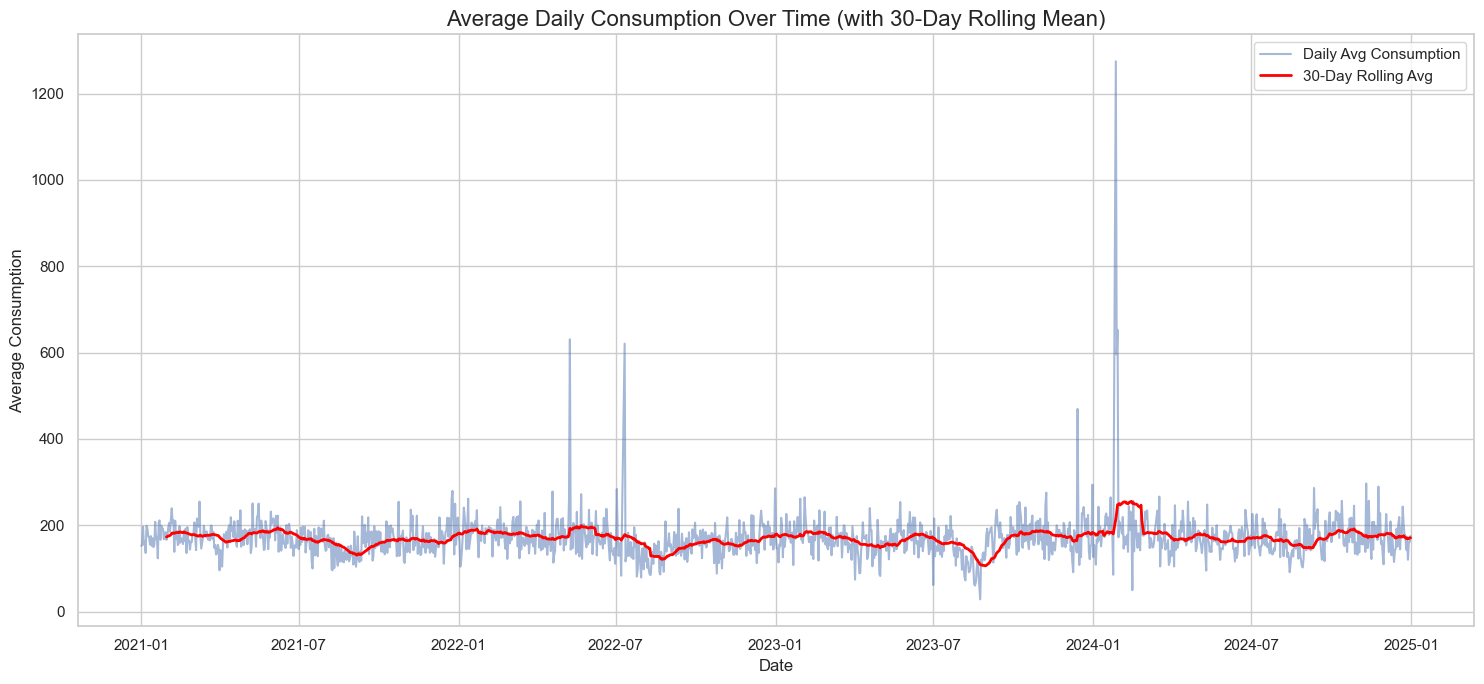


--- 2. Generating Consumption Histograms ---


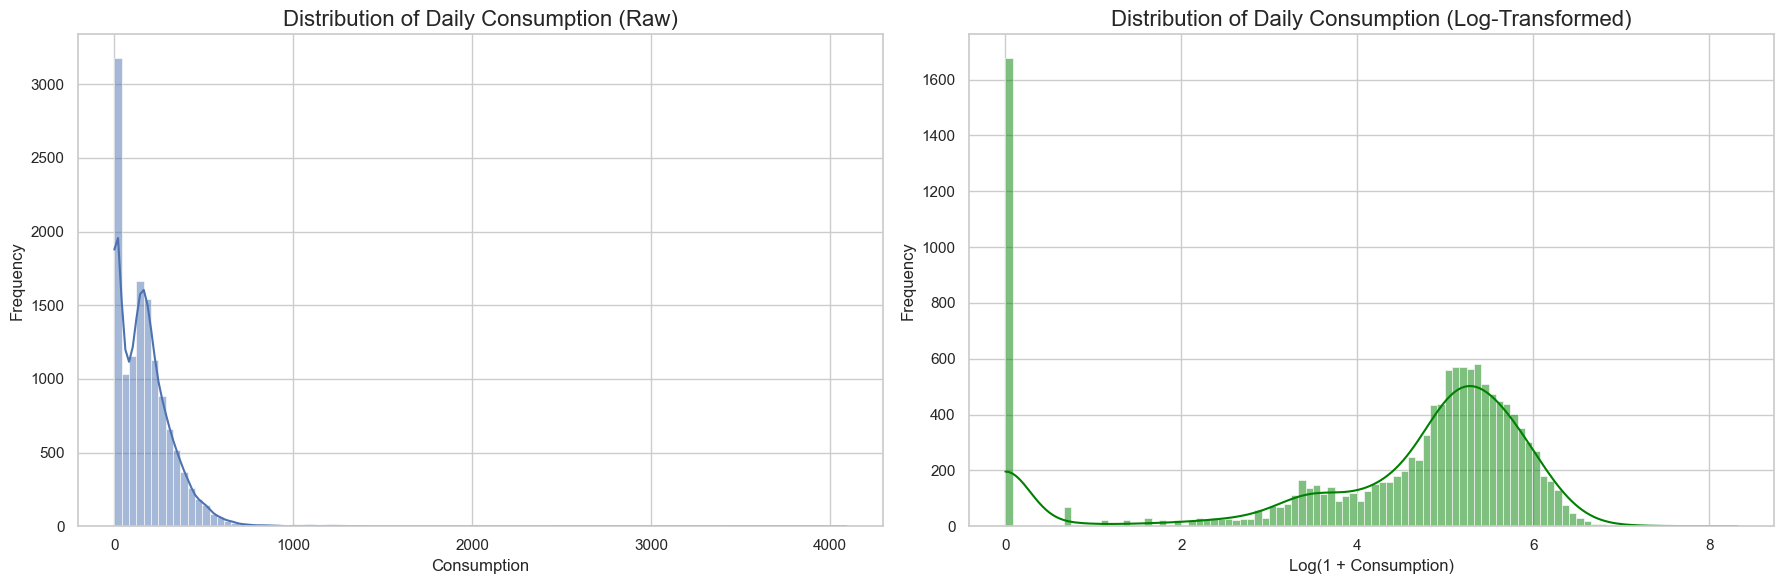


--- 3. Generating Boxplot by Meter Brand (MARCA_COMP) ---


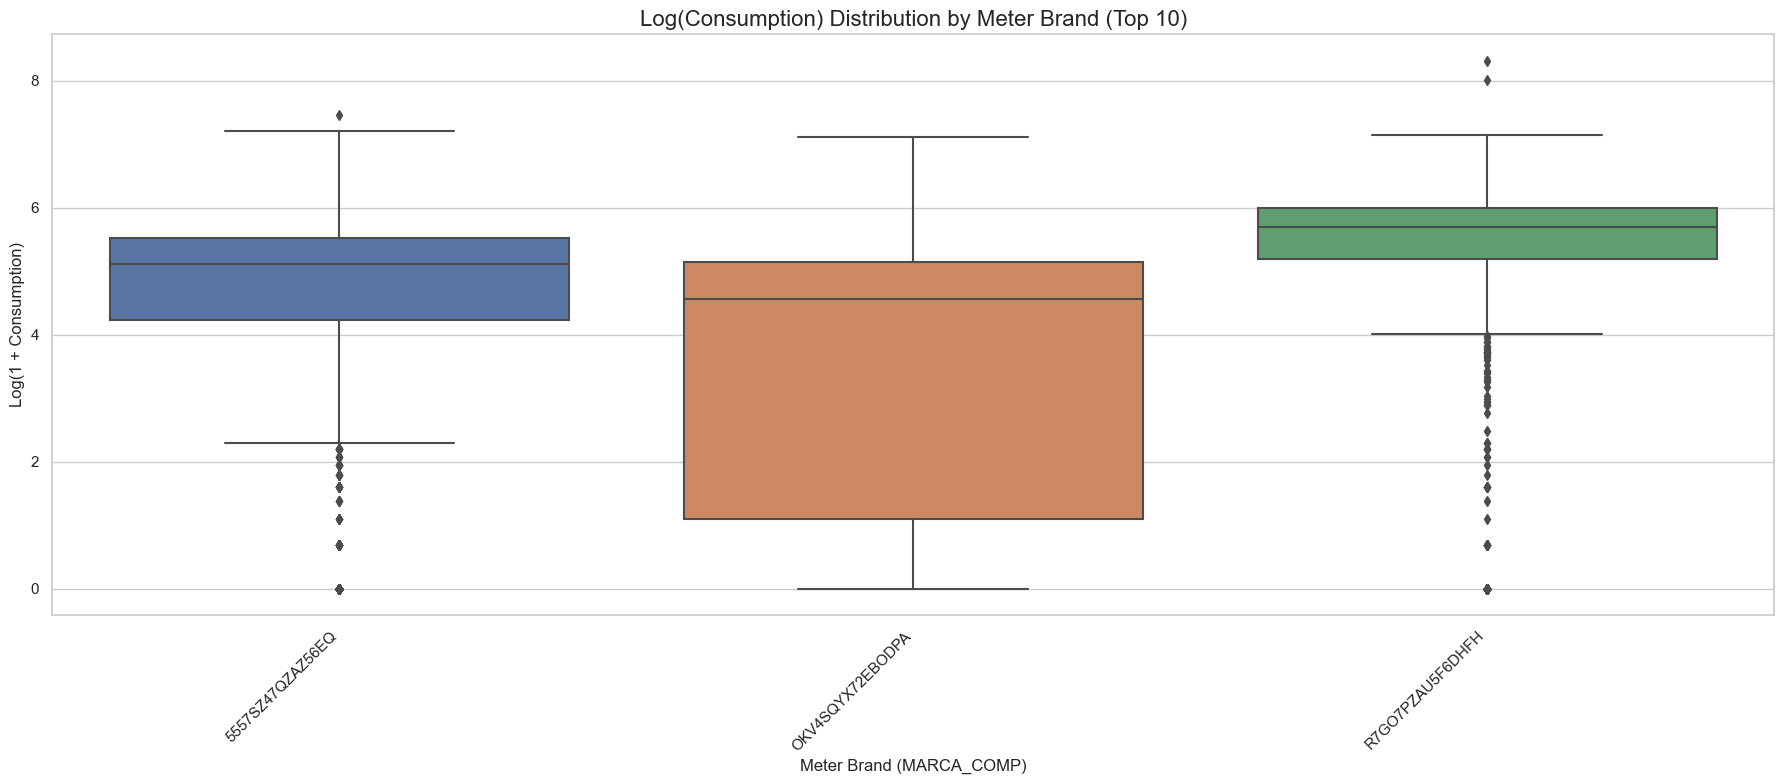


--- 4. Generating Correlation Heatmap ---


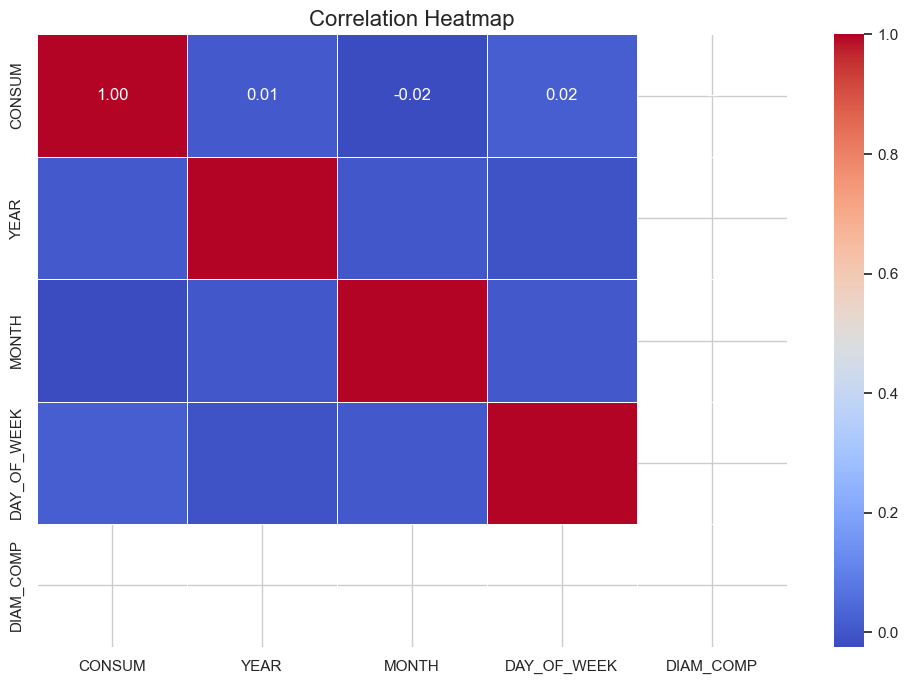


--- 5. Identifying Outliers (Potential Malfunctions) ---
  - Total records: 12986
  - Total outliers identified (Z-score > 3 on log-data): 108

  - Outlier count by Meter Brand (Top 5):
MARCA_COMP
5557SZ47QZAZ56EQ    74
R7GO7PZAU5F6DHFH    29
OKV4SQYX72EBODPA     5
Name: count, dtype: int64

  - Outlier examples:
          POLISSA_SUBM       DATA  CONSUM       NUM_COMPLET DATA_INST_COMP  \
553   4XFL2NAR75V6CQIG 2022-07-11   825.0  IBU3QNDABEVUQA7J     2016-07-20   
1116  4XFL2NAR75V6CQIG 2024-01-29  1070.0  IBU3QNDABEVUQA7J     2016-07-20   
2007  6IK7MA7VMNEXSX4X 2022-07-11   918.0  ZVNZFWCBRKJU753Y     2016-04-21   
2570  6IK7MA7VMNEXSX4X 2024-01-29  1215.0  ZVNZFWCBRKJU753Y     2016-04-21   
3381  ESMNMUDLAMOYLGGR 2022-04-19   861.0  NT5COFRJE6JWUUJM     2015-07-06   

            MARCA_COMP CODI_MODEL  DIAM_COMP  YEAR  MONTH  DAY_OF_WEEK  \
553   5557SZ47QZAZ56EQ         31       15.0  2022      7            0   
1116  5557SZ47QZAZ56EQ         31       15.0  2024      1          

In [14]:
print("--- Starting Step 2: Exploratory Data Analysis ---")

# Filter the DataFrame to keep only rows where POLISSA_SUBM is NOT the specified ID
unified_df = unified_df[unified_df['POLISSA_SUBM'] != '6C3M54YW4J6HKY26']
if 'unified_df' in locals() and not unified_df.empty:
    
    # --- 1. Time Series Plot (Overall Consumption) ---
    print("\n--- 1. Generating Time Series Plot ---")
    try:
        # Resample to daily average consumption to get a clearer trend
        daily_avg_consum = unified_df.groupby('DATA')['CONSUM'].mean().reset_index()
        daily_avg_consum.set_index('DATA', inplace=True)
        
        # Apply a 30-day rolling mean to smooth the series
        daily_avg_consum['CONSUM_ROLLING_AVG'] = daily_avg_consum['CONSUM'].rolling(window=30).mean()
        
        plt.figure(figsize=(15, 7))
        plt.plot(daily_avg_consum.index, daily_avg_consum['CONSUM'], label='Daily Avg Consumption', alpha=0.5)
        plt.plot(daily_avg_consum.index, daily_avg_consum['CONSUM_ROLLING_AVG'], label='30-Day Rolling Avg', color='red', linewidth=2)
        plt.title('Average Daily Consumption Over Time (with 30-Day Rolling Mean)', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Average Consumption', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating time series plot: {e}")
    
    # --- 2. Histograms (Consumption Distribution) ---
    print("\n--- 2. Generating Consumption Histograms ---")
    try:
        plt.figure(figsize=(18, 6))
        
        # Plot 1: Raw Consumption
        plt.subplot(1, 2, 1)
        sns.histplot(unified_df['CONSUM'], bins=100, kde=True)
        plt.title('Distribution of Daily Consumption (Raw)', fontsize=16)
        plt.xlabel('Consumption', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        
        # Plot 2: Log-Transformed Consumption (pre-calculated in Step 1)
        plt.subplot(1, 2, 2)
        sns.histplot(unified_df['CONSUM_LOG'], bins=100, kde=True, color='green')
        plt.title('Distribution of Daily Consumption (Log-Transformed)', fontsize=16)
        plt.xlabel('Log(1 + Consumption)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating histograms: {e}")

    # --- 3. Boxplot by Meter Characteristic (MARCA_COMP) ---
    print("\n--- 3. Generating Boxplot by Meter Brand (MARCA_COMP) ---")
    try:
        # Check if 'MARCA_COMP' is available
        if 'MARCA_COMP' in unified_df.columns:
            # Get top 10 brands by record count for a cleaner plot
            top_10_brands = unified_df['MARCA_COMP'].value_counts().head(10).index
            df_top_10_brands = unified_df[unified_df['MARCA_COMP'].isin(top_10_brands)]
            
            plt.figure(figsize=(18, 8))
            # Use the log-transformed consumption for better visualization of variance
            sns.boxplot(data=df_top_10_brands, x='MARCA_COMP', y='CONSUM_LOG', order=top_10_brands)
            plt.title('Log(Consumption) Distribution by Meter Brand (Top 10)', fontsize=16)
            plt.xlabel('Meter Brand (MARCA_COMP)', fontsize=12)
            plt.ylabel('Log(1 + Consumption)', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print("  - 'MARCA_COMP' column not found. Skipping boxplot.")
    except Exception as e:
        print(f"Error generating boxplot: {e}")
        
    # --- 4. Correlation Heatmap ---
    print("\n--- 4. Generating Correlation Heatmap ---")
    try:
        # Include 'DIAM_COMP' (meter diameter) if it exists
        corr_features = ['CONSUM', 'YEAR', 'MONTH', 'DAY_OF_WEEK']
        if 'DIAM_COMP' in unified_df.columns:
            corr_features.append('DIAM_COMP')
            
        corr_matrix = unified_df[corr_features].corr()
        
        plt.figure(figsize=(10, 7))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap', fontsize=16)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating heatmap: {e}")
        
    # --- 5. Identify Outliers/Indicators of Malfunction ---
    print("\n--- 5. Identifying Outliers (Potential Malfunctions) ---")
    try:
        # Use Z-score on the log-transformed data
        unified_df['CONSUM_LOG_ZSCORE'] = stats.zscore(unified_df['CONSUM'])
        
        # Identify outliers (e.g., Z-score > 3 or < -3)
        outliers = unified_df[
            (unified_df['CONSUM_LOG_ZSCORE'] > 3) | 
            (unified_df['CONSUM_LOG_ZSCORE'] < -3)
        ]
        
        print(f"  - Total records: {len(unified_df)}")
        print(f"  - Total outliers identified (Z-score > 3 on log-data): {len(outliers)}")
        
        if not outliers.empty:
            print("\n  - Outlier count by Meter Brand (Top 5):")
            if 'MARCA_COMP' in outliers.columns:
                print(outliers['MARCA_COMP'].value_counts().head(5))
            else:
                print("  - 'MARCA_COMP' column not found.")
            
            print("\n  - Outlier examples:")
            print(outliers.head())
        else:
            print("  - No significant outliers found.")
    except Exception as e:
        print(f"Error identifying outliers: {e}")

else:
    print("\nPipeline skipped as 'unified_df' was not created successfully in Step 1.")

print("\n--- EDA Pipeline Finished ---")